In [504]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import seaborn as sns

%matplotlib inline

### 1. Чтение данных

In [548]:
df = pd.read_csv('C:/Users/yana/realestatepriceprediction/train.csv')
X_final = pd.read_csv('C:/Users/yana/realestatepriceprediction/test.csv')

In [549]:
# уменьшение потребляемой памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [550]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.937500
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.437500
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.234375
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.312500
9996,6159,18,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.296875
9997,5123,27,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.812500
9998,5400,75,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.343750


In [551]:
reduce_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882645,33.432781,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263184,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597818,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046608,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809795,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198471,21.807060,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282623,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


In [552]:
X = df.drop('Price', axis=1)
y = df[['Price']]

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()

Строк в трейне: 10000
Строк в тесте 5000


7272

In [532]:
X.isnull().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


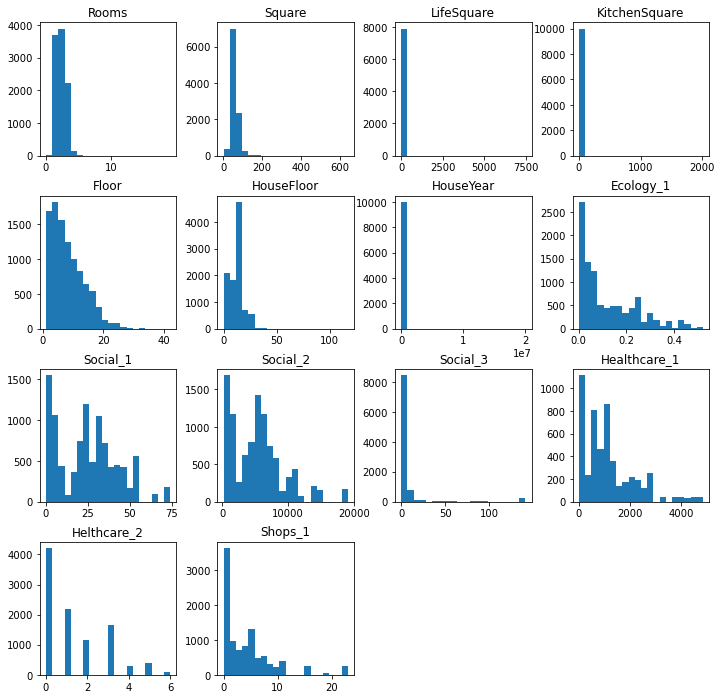

In [486]:
X_num_features = X.select_dtypes(exclude=['category'])
X_num_features.drop(['DistrictId'], axis=1, inplace=True)
X_num_features.hist(figsize=(12,12), bins=20, grid=False);

### 2. Очистка данных

In [553]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Square
            # Если общая площадь больше жилой, поменяем их значения местами
        array = np.where((X['Square'] - X['LifeSquare'] > 0) | ((X['Square'] - X['LifeSquare']).isnull()) , [X['Square'],
            X['LifeSquare']], [X['LifeSquare'], X['Square']])
        X['Square'] = array[0]
        X['LifeSquare'] = array[1]
         
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < np.quantile(X['Square'], q=0.002)) | (X['Square'] >np.quantile(X['Square'], q=0.999)), 'Square_outlier'] = 1
        
        X['Square'] = np.where(X['Square'] > np.quantile(X['Square'], q=0.002),X['Square'],np.quantile(X['Square'], q=0.002))
        X['Square'] = np.where(X['Square'] < np.quantile(X['Square'], q=0.999),X['Square'],np.quantile(X['Square'], q=0.999))
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        ls_median = (X['LifeSquare'] / X['Square']).median()
        X['LifeSquare'] = X['LifeSquare'].fillna(X['Square'] * ls_median)
        X['LifeSquare'] = np.where(X['LifeSquare'] / X['Square']> 0.5,X['LifeSquare'],X['Square'] * 0.5)
        
        # KitchenSquare
        X['KitchenSquare'] = np.where(X['KitchenSquare'] >=3, X['KitchenSquare'], self.medians['KitchenSquare'])
        X['KitchenSquare'] = np.where(X['Square'] - X['LifeSquare'] - X['KitchenSquare'] >= 2, X['KitchenSquare'], X['Square'] - X['LifeSquare']-2)
        X['KitchenSquare'] = np.where(X['KitchenSquare']>=3, X['KitchenSquare'], 3)
        X['LifeSquare'] = np.where(X['Square'] - X['LifeSquare'] - X['KitchenSquare'] >= 2, X['LifeSquare'], X['Square'] - X['KitchenSquare']-2)
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        median_rooms = (X['LifeSquare'] / X['Rooms']).median()
        X['Rooms'] = np.where(X['Rooms'] > 0, X['Rooms'], X['LifeSquare'] // median_rooms)
        X['Rooms'] = np.where(X['Rooms'] < 6, X['Rooms'], X['LifeSquare'] // median_rooms)
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] > 5, 'Rooms'] = 5
        
                
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] > 48, 'HouseFloor_outlier'] = 1

        X.loc[X['HouseFloor'] <= X['Floor'], 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] > 48, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['HouseFloor'] <= X['Floor'], 'HouseFloor'] = X['Floor']

        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] < 1930, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        X.loc[X['HouseYear'] <= 1920, 'HouseYear'] = X['HouseYear'] + 100
        
        # Остальное
        X['Ecology_1'] = np.where(X['Ecology_1'] != 0, X['Ecology_1'], X.groupby('DistrictId')['Ecology_1'].median()[X['DistrictId']])
        X['Social_1'] = np.where(X['Social_1'] != 0, X['Social_1'], X.groupby('DistrictId')['Social_1'].median()[X['DistrictId']])
        X['Social_2'] = np.where(X['Social_2'] != 0, X['Social_2'], X.groupby('DistrictId')['Social_2'].median()[X['DistrictId']])
        X['Social_3'] = np.where(X['Social_3'] != 0, X['Social_3'], X.groupby('DistrictId')['Social_3'].median()[X['DistrictId']])
        X['Shops_1'] = np.where(X['Shops_1'] != 0, X['Shops_1'], X.groupby('DistrictId')['Shops_1'].median()[X['DistrictId']])
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        return X

In [554]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

In [555]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

### 3. Feature engineering

In [556]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.DistrictId_counts_ALL = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district1 = X['DistrictId'].value_counts()
        district = district1[district1 > 50]  
        
        self.DistrictId_counts = dict(district)
        self.DistrictId_counts_ALL = dict(district1)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['Price_per_sqm'] = df['Price'] / df['Square']
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price_per_sqm':'median'}).\
                                            rename(columns={'Price_per_sqm':'MedSQMPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df['Price_per_sqm'] = df['Price'] / df['Square']
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price_per_sqm':'median'}).\
                                            rename(columns={'Price_per_sqm':'MedSQMPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts_ALL)
        X['DistrictId_count'].fillna(1, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 2, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 2) & (X['Floor'] <= 6), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 6) & (X['Floor'] <= 19), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 19) & (X['Floor'] <= 32), 'floor_cat'] = 4
        X.loc[X['Floor'] > 32, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        year_count = X['HouseYear'].value_counts()
        year_count = dict(year_count)
        X['year_count'] = X['HouseYear'].map(year_count) 
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1947, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1947) & (X['HouseYear'] <= 1955), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1955) & (X['HouseYear'] <= 1990), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1990) & (X['HouseYear'] <= 2015), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2015), 'year_cat'] = 5
            
        return X

In [557]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [558]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                   'Shops_1', 'Square_outlier', 'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear', 'floor_cat', 'year_cat',                    
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedSQMPriceByDistrict', 'MedSQMPriceByFloorYear']

X = X[remain_features]
X_final = X_final[remain_features]

In [559]:
X['MedSQMPriceByDistrict'].fillna(0, inplace=True)
X['MedSQMPriceByFloorYear'].fillna(0, inplace=True)

In [560]:
X_final['MedSQMPriceByDistrict'].fillna(0, inplace=True)
X_final['MedSQMPriceByFloorYear'].fillna(0, inplace=True)

In [561]:
X_final['Ecology_2']= X_final['Ecology_2'].astype('int8')
X_final['Ecology_3']= X_final['Ecology_3'].astype('int8')
X_final['Shops_2']= X_final['Shops_2'].astype('int8')

In [562]:
X['Ecology_2']= X['Ecology_2'].astype('int8')
X['Ecology_3']= X['Ecology_3'].astype('int8')
X['Shops_2']= X['Shops_2'].astype('int8')

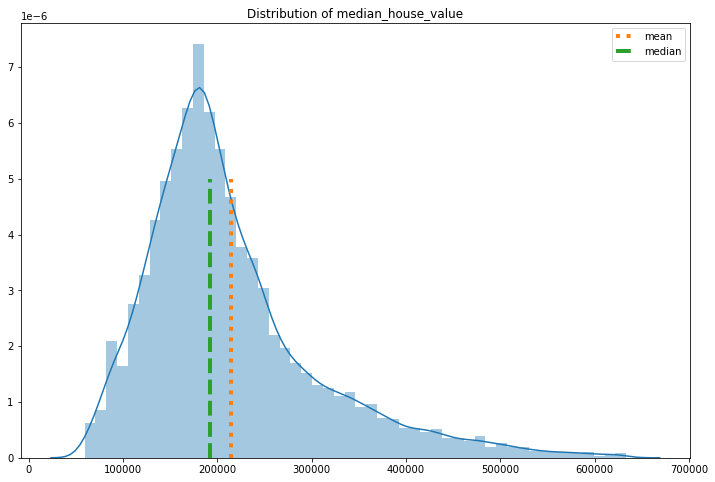

In [563]:
target_mean = round(y.mean(), 2)
target_median = y.median()

plt.figure(figsize = (12, 8))

sns.distplot(y)

a = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, a, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, a, label='median', linestyle='--', linewidth=4)


plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [566]:
lgbm_model = LGBMRegressor(max_depth=5, num_leaves=200, learning_rate=0.05, n_estimators=500)

cv_score = cross_val_score(lgbm_model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.749 +- 0.017


In [564]:
parameters = [{'n_estimators': [200, 300, 400, 500], 'max_depth': np.arange(4, 8), 
               'num_leaves':[200, 300, 400], 'learning_rate': [0.01, 0.05, 0.1]}] 

clf = GridSearchCV(estimator=LGBMRegressor(), param_grid=parameters, scoring='r2', cv=3)
clf.fit(X, y.values[:,0])

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid=[{'learning_rate': [0.01, 0.05, 0.1],
                          'max_depth': array([4, 5, 6, 7]),
                          'n_estimators': [200, 300, 400, 500],
                          'num_leaves': [200, 300, 400]}],
             scoring='r2')

In [565]:
clf.best_params_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 200}

In [ ]:
#lgbm_model.fit(X, y)

In [116]:
#feature_importances = lgbm_model.feature_importances_
#A = pd.Series(feature_importances, index=X.columns)
#A.sort_values().head(10)

year_cat               0
floor_cat              0
Rooms_outlier          0
Ecology_3              1
new_district           1
Ecology_2              5
Shops_2               19
HouseYear_outlier     21
Square_outlier        28
HouseFloor_outlier    49
dtype: int32

In [569]:
rfr_model = RandomForestRegressor(n_estimators=1200, max_depth=15, random_state = 42)

cv_score = cross_val_score(rfr_model, X, y.values[:,0], 
                           scoring='r2', 
                           cv=5)
# cv_score
mean = cv_score.mean()
std = cv_score.std()
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.734 +- 0.020


In [570]:
#rfr_model.fit(X, y.values[:,0])
#feature_importances = rfr_model.feature_importances_
#A = pd.Series(feature_importances, index=X.columns)
#A.sort_values().head(10)

Rooms_outlier         0.000047
Square_outlier        0.000166
Ecology_2             0.000268
HouseYear_outlier     0.000423
Ecology_3             0.000450
new_district          0.000652
Shops_2               0.001186
year_cat              0.001803
HouseFloor_outlier    0.002049
LifeSquare_nan        0.002201
dtype: float64

In [576]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.05,
    iterations=1100,
    eval_metric='R2',
    depth=7)

cv_score = cross_val_score(cb_model, X, y.values[:,0], 
                           scoring='r2', 
                           cv=5)
#cv_score
mean = cv_score.mean()
std = cv_score.std()
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.753 +- 0.013


In [316]:
#cb_model.fit(X, y.values[:,0])
#feature_importances = cb_model.feature_importances_
#A = pd.Series(feature_importances, index=X.columns)
#A.sort_values().head(10)

new_district          0.000000
Rooms_outlier         0.001109
HouseYear_outlier     0.003380
Ecology_2             0.006348
Ecology_3             0.040792
Square_outlier        0.157627
Shops_2               0.201921
LifeSquare_nan        0.357449
HouseFloor_outlier    0.481802
year_cat              0.553391
dtype: float64

In [588]:
gb_model = GradientBoostingRegressor(n_estimators=350, max_depth=5, min_samples_split=3, 
                                              learning_rate=0.05, random_state=42)
cv_score = cross_val_score(gb_model, X, y.values[:,0], 
                           scoring='r2', 
                           cv=5)
# cv_score
mean = cv_score.mean()
std = cv_score.std()
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.745 +- 0.017


In [592]:
vreg = VotingRegressor([('cb', cb_model),('lgbm',lgbm_model),('gb',gb_model)])
cv_score = cross_val_score(vreg, X, y.values[:,0], 
                         scoring='r2', 
                         cv=5)
# cv_score
mean = cv_score.mean()
std = cv_score.std()
print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.753 +- 0.015


In [593]:
vreg.fit(X, y.values[:,0])

VotingRegressor(estimators=[('cb',
                             <catboost.core.CatBoostRegressor object at 0x000001D260502748>),
                            ('lgbm',
                             LGBMRegressor(learning_rate=0.05, max_depth=5,
                                           n_estimators=500, num_leaves=200)),
                            ('gb',
                             GradientBoostingRegressor(learning_rate=0.05,
                                                       max_depth=5,
                                                       min_samples_split=3,
                                                       n_estimators=350,
                                                       random_state=42))])

In [594]:
y_pred_final = vreg.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,144888.046879
1,15856,225343.977310
2,5480,249330.575911
3,15664,336655.844597
4,14275,143620.528347
